In [1]:
# --<Environment Libs>--
from dataclasses import dataclass, field
import sys, os, subprocess  
import pip, time

# --<DataScience>--
import seaborn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


# --<Feature Engineering>--
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from scipy.interpolate import interp1d
from scipy.interpolate import BSpline, splrep


assert sys.version_info >= (3, 5)
bScale: bool = False
SingleSet: bool = True


<img src="./hyst_loop.jpg" alt="Hysteresis P/V Loop" style="opacity: 0.8;" />


In [2]:
#setups
plt.style.use('dark_background')
csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

In [3]:
def Load_LowFeq_sets():
    os.chdir("/home/molderon/Main/WorkSpace/Diploma Project/Feature Engineering/")
    Scale_Dataset = StandardScaler()

    try:
        if(SingleSet == False):
            Training_Set = pd.DataFrame()
            MultiCalss_validation = pd.DataFrame()
            CrossValidation = pd.DataFrame()

            Training_Set = pd.read_csv("TrainingSet.csv")
            MultiCalss_validation = pd.read_csv("MultiValid.csv")
            CrossValidation = pd.read_csv("CrossValid.csv")

            # Renaming bad naming concentions
            Training_Set.columns = Training_Set.columns.str.replace("u_in", "TV-i")
            Training_Set.columns = Training_Set.columns.str.replace("u_out", "TV-e")
            MultiCalss_validation.columns = MultiCalss_validation.columns.str.replace("u_in", "TV-i")
            MultiCalss_validation.columns = MultiCalss_validation.columns.str.replace("u_out", "TV-e")
            CrossValidation.columns = CrossValidation.columns.str.replace("u_in", "TV-i")
            CrossValidation.columns = CrossValidation.columns.str.replace("u_out", "TV-e")

            #Droping useless weight
            Training_Set.dropna()
            MultiCalss_validation.dropna()
            CrossValidation.dropna()

            Training_Set = Training_Set.dropna(subset=['pressure'])
            MultiCalss_validation = MultiCalss_validation.dropna(subset=['pressure'])
            CrossValidation = CrossValidation.dropna(subset=['pressure'])

            Training_Set.drop(Training_Set.columns[[0,1]], axis =1, inplace=True)
            CrossValidation.drop(CrossValidation.columns[[0,1]], axis =1, inplace=True)
            MultiCalss_validation.drop(MultiCalss_validation.columns[[0,1]], axis =1, inplace=True)

            # Optional Scaling

            if bScale == True:
                Training_Set = Scale_Dataset(Training_Set)
                MultiCalss_validation = Scale_Dataset(MultiCalss_validation)
                CrossValidation = Scale_Dataset(CrossValidation)

            print(Training_Set.describe())
            return Training_Set, MultiCalss_validation, CrossValidation

        else:
            Full_Dataset = pd.DataFrame()
            Full_Dataset = pd.read_csv("Default_MV_Data.csv")

            Full_Dataset.columns = Full_Dataset.columns.str.replace("u_in", "TV-i")
            Full_Dataset.columns = Full_Dataset.columns.str.replace("u_out", "TV-e")
            Full_Dataset.drop(Full_Dataset.columns[[0,1]], axis =1, inplace=True)
            Full_Dataset.dropna()

            if bScale == True:
                Full_Dataset = Scale_Dataset(Full_Dataset)

            return Full_Dataset
        
    except Exception:
        print(Exception.with_traceback())
        return None

In [59]:
Training_Set.iloc[:,1:].hist(bins = 50, figsize=(20,15))

array([[<Axes: title={'center': 'R'}>, <Axes: title={'center': 'C'}>],
       [<Axes: title={'center': 'time_step'}>,
        <Axes: title={'center': 'TV-i'}>],
       [<Axes: title={'center': 'TV-e'}>,
        <Axes: title={'center': 'pressure'}>]], dtype=object)

># ⚠️ **Conditional Warning: Time-Intensive Operation**
> **Condition: Datasets larger than: 300 Mbytes**

In [ ]:
def Draw_ScatterMatrix(Dataset: pd.DataFrame):    
    set_attributes: list = ["pressure", "TV-e", "TV-i","R", "C", "time_step"]
    scatter_matrix(Dataset[set_attributes], figsize=(12,8))

<img src="./Scatter_Matrix.png" alt="Scatter Matrix" style="opacity: 1;" />

## >> |Open Questions
- Q: What is the data frequency of an individual Breath ?
- A: Frequency ​≈ 16.67 Hz
- Q: Does the timestep for individual readings remain **consistant** ?
- A: Not consistant, it's voletile between the ranges **(59 - 64 miliseconds)**

## Conclusions:
- (16.67)Hz * (60)milliseconds = 1 sec.
- Avg. breath cycle is 2.7 sec = **~ (50 * 7)** datapoints per breath

## >> |Feature Engineering
- Feature **A)** Reconstruction of sythetic datapoints: **Increase frequiency to ~ (32)Hz/sec.**
- Feature **B)** Create a custom **Hysteresis Cycle Metric** for each breath id.

<img src="./boosted.png" alt="Scatter Matrix" style="opacity: 1;" />

>## Interpolation of each Dataset
- Training Set
- MultiClass_validation Set
- Corss-Validation Set

In [22]:
def Example_Dataset(DataSet: pd.DataFrame):
    ExampleSet = pd.DataFrame()
    gss = GroupShuffleSplit(test_size=0.70, random_state=42) # loads 10% of Given Dataset
    for idx, _ in gss.split(DataSet, groups=DataSet['breath_id']):
        ExampleSet = DataSet.iloc[idx]
    return ExampleSet

In [5]:
# '0' == 2x the dataset Frequiency
# 'n' == 2x+n the dataset Frequency
Interloper: int = 10

In [101]:
def Reconstruct_Cycle(DataSet: pd.DataFrame, Single_Cycle: pd.DataFrame, Interloper: int):
    X_features = Single_Cycle[['time_step', 'R', 'C', 'TV-i', 'TV-e']].values
    Y_target = Single_Cycle['pressure'].values

    Interloper += (Single_Cycle.shape[0] - 15)
    #Hard-Cap, data becomes to noise
    if(Interloper > 60): Interloper = 60
    Synthetic_Timestep = np.linspace(Single_Cycle['time_step'].min(), Single_Cycle['time_step'].max(), Interloper)

    Symetra = splrep(Single_Cycle['time_step'], Y_target, s=0)
    Pressure_Prediction = BSpline(*Symetra)(Synthetic_Timestep)

    def reconstruct_variable(target_column):
        Y_target = Single_Cycle[target_column].values
        tck = splrep(Single_Cycle['time_step'], Y_target, s=3)  
        return BSpline(*tck)(Synthetic_Timestep)

    # Reconstruct other variables
    TV_i_pred = reconstruct_variable('TV-i')
    TV_e_pred = reconstruct_variable('TV-e')
    R_pred = reconstruct_variable('R')
    C_pred = reconstruct_variable('C')

    breath_id = Single_Cycle['breath_id'].values[0]
    Interpolated_Data = pd.DataFrame({
        'breath_id': np.full(Synthetic_Timestep.shape, breath_id),  
        'C': C_pred,
        'time_step': Synthetic_Timestep,
        'TV-i': TV_i_pred,
        'TV-e': TV_e_pred,
        'pressure': Pressure_Prediction
    })
    Interloper = 0
    DataSet = pd.concat([DataSet, Interpolated_Data], ignore_index=True)
    
    return DataSet

In [98]:
def Reconstruct_Dataset(DataSet: pd.DataFrame, dataset_name: str, Interloper:int)-> pd.DataFrame:
    Single_Cycle = pd.DataFrame()
    for breath_id, group in DataSet.groupby('breath_id'):
        Single_Cycle = group.sort_values(by='time_step').copy()
        DataSet = Reconstruct_Cycle(DataSet, Single_Cycle, Interloper)

    DataSet.to_csv(dataset_name)
    
    return DataSet

># ⚠️ **Warning: Time-Intensive Operation**
>
> The interpolation process you're about to run is computationally expensive and may take **several hours** to complete, the author advices to use small sliced datasets.
># **Beware**
>
> - Ensure that your system has sufficient resources (CPU/RAM) to handle the process.
> - Avoid interrupting the process once it has started.
> - If possible, run this operation on a machine that will not be needed for other tasks during execution.


# Data Interpolation
 **Default Datapoints (Left) - 16 Hz/sec**   |   **Interpolation (Right) - 32 Hz/sec**

In [96]:
def Interpolation():
      import time,warnings
      # Suppress specific Pandas warnings
      warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
      warnings.filterwarnings("ignore")
      Boosted_Dataset = pd.DataFrame()
      start = time.time()
      pd.options.mode.chained_assignment = None
      
      Boosted_Dataset = Load_LowFeq_sets()      
      Boosted_Dataset = Reconstruct_Dataset(Boosted_Dataset, "Boosted_MV.csv", Interloper)
      
      ''' //Example for splitted sets
            Boosted_TrainingSet = Reconstruct_Dataset(Training_Set,"Boosted_TrainingSet.csv.csv", Interloper)
            Boosted_MultiClass =  Reconstruct_Dataset(CrossValidation,"Boosted_MultiClass.csv", Interloper)
            Boosted_CrossValidation = Reconstruct_Dataset(MultiCalss_validation,"Boosted_CrossValidation.csv", Interloper)
      '''
      
      end = time.time()
      print("Total time for interpolations is :",
            (end-start)/60, "Min")

In [111]:
Interpolation()

Total time for interpolations is : 229.17649847269058 Min


### Interpolation Description:


1. **Input Features**: 
   $$
   X = [\text{time\_step}, R, C, TV_{i}, TV_{e}] \in \mathbb{R}^{n \times m}
   $$
   where \(n\) is the number of samples and \(m\) is the number of features.

   - \(Y\) is defined as the target variable:
   $$
   Y = \text{pressure} \in \mathbb{R}^{n}
   $$

2. **Synthetic Time Steps**: 
   - The number of interpolated points  :
   $$
   n_{\text{interloper}} = n + I
   $$
   where \(I\) is the additional points specified by the user.

   - A synthetic time step vector is created:
   $$
   t_{\text{synthetic}} = \text{linspace}(t_{\text{min}}, t_{\text{max}}, n_{\text{interloper}})
   $$

3. **Pressure Prediction Using B-Splines**: 
   - The B-spline representation of the pressure is generated using the `splrep` function:
   $$
   tck_{\text{pressure}} = \text{splrep}(S[\text{time\_step}], Y, s=0)
   $$
   - The predicted pressure values at synthetic time steps are calculated as:
   $$
   P_{\text{pred}} = BSpline(tck_{\text{pressure}})(t_{\text{synthetic}})
   $$

4. **Variable Reconstruction**:
   - A nested function is defined to reconstruct other variables in the dataset:
   $$
   V_{\text{pred}} = BSpline(tck_{\text{variable}})(t_{\text{synthetic}})
   $$

   - This is computed as:
   $$
   tck_{\text{variable}} = \text{splrep}(S[\text{time\_step}], S[\text{variable}], s=3)
   $$

5. **Constructing the Output DataFrame**: 
   - Finally, an interpolated dataset \(I\) is created:
   $$
   I = \begin{bmatrix}
   \text{breath\_id} & C_{\text{pred}} & t_{\text{synthetic}} & TV_{i_{\text{pred}}} & TV_{e_{\text{pred}}} & P_{\text{pred}} \\
   \end{bmatrix}
   $$

   - The final reconstructed dataset is obtained by concatenating the original dataset \(D\) with the interpolated data \(I\):
   $$
   D_{\text{new}} = D \cup I
   $$

<img src="./17Hz.png" alt="Scatter Matrix" style="opacity: 1;" />
<img src="./32Hz.png" alt="Scatter Matrix" style="opacity: 1;" />

In [19]:
Boosted_Dataset = pd.read_csv("Boosted_MV.csv")

In [20]:
Boosted_Dataset.drop(Boosted_Dataset.columns[[0]], axis=1, inplace=True)
Boosted_Dataset.head()

,breath_id,R,C,time_step,TV-i,TV-e,pressure
0,1.0,20.0,50.0,0.000000,0.083334,0.0,5.837492
1,1.0,20.0,50.0,0.033652,18.383041,0.0,5.907794
2,1.0,20.0,50.0,0.067514,22.509278,0.0,7.876254
3,1.0,20.0,50.0,0.101542,22.808822,0.0,11.742872
4,1.0,20.0,50.0,0.135756,25.355850,0.0,12.234987


In [13]:
def Plot_Hysteresis(Hysteresis_Dynamics: pd.DataFrame):
    TV_i = np.array(Hysteresis_Dynamics['TV-i'])
    TV_e = np.array(Hysteresis_Dynamics['TV-e'])
    pressure = np.array(Hysteresis_Dynamics['pressure'])

    TV_total = TV_i + TV_e

    plt.ion() 
    fig, ax = plt.subplots()
    line, = ax.plot([], [], marker='o', linestyle='-', color='b', label='Hysteresis (TV-total / Pressure)')

    ax.set_title('Hysteresis Loop: TV-total/Pressure - 32Hz')
    ax.set_xlabel('TV-total (TV-i + TV-e)')
    ax.set_ylabel('Pressure')
    ax.legend()

    def update_plot(x_data, y_data):
        line.set_data(x_data, y_data)
        ax.relim()          
        ax.autoscale_view() 
        fig.canvas.draw()   
        fig.canvas.flush_events() 

    for i in range(len(TV_total)):
        update_plot(TV_total[:i+1], pressure[:i+1])

    plt.ioff()
    plt.show()

># Polynomial Hysteresis Area 

In [25]:
def polynomial_area(Hysteresis_Sample: pd.DataFrame):
    Tidal_Volume = Hysteresis_Sample["TV-i"] +  Hysteresis_Sample["TV-e"]
    Apparent_Pressure = Hysteresis_Sample["pressure"]
    Polynomial_Area = np.abs(np.trapz(Apparent_Pressure, Tidal_Volume))

    Hysteresis_Sample["Polynomial_Area"] = Polynomial_Area

    return Hysteresis_Sample


def Feature_HysteresisArea(DataSet: pd.DataFrame):
    DataSet = DataSet.sort_values(by=['breath_id', 'time_step']).copy()
    Featurefull_Rows = []

    for breath_id, group in DataSet.groupby('breath_id'):
        Hysteresis_Sample = polynomial_area(group)  
        Featurefull_Rows.append(Hysteresis_Sample)

    DataSet = pd.concat(Featurefull_Rows, ignore_index=True)

    return DataSet


>## Feature Engineering
- **Pressure/Volume Loop** 

In [26]:
def Hysteresis_Area_Metric(Full_Dataset: pd.DataFrame):
    os.chdir("/home/molderon/Main/WorkSpace/Diploma Project/Classification Algorithms/")
    start_time = time.time()

    if(SingleSet == False):
        Boosted_TrainingSet = Feature_HysteresisArea(Boosted_TrainingSet)
        Boosted_TrainingSet.to_csv("Cluster_TrainingSet.csv")

        Boosted_MultiClass = Feature_HysteresisArea(Boosted_MultiClass)
        Boosted_MultiClass.to_csv("Cluster_MultiClass.csv")

        Boosted_CrossValidation= Feature_HysteresisArea(Boosted_CrossValidation)
        Boosted_CrossValidation.to_csv("Cluster_CrossValid.csv")
    else:
        Full_Dataset = Feature_HysteresisArea(Full_Dataset)
        Full_Dataset.to_csv("Full_CusterSet.csv")

    end_time = time.time()

    print("Execution time:", (end_time - start_time)/60, "::mins")

# |Creating P/V cycles as a feature
- **Working with the Interloped Datasets _~(32Hz)~_**

- **The area of the polygon can be calculated using the formula:**

$$
A = \frac{1}{2} \left| \sum_{i=1}^{n} \left( x_i \cdot y_{i+1} - y_i \cdot x_{i+1} \right) \right|
$$

Where:
- \(x_i\) and \(y_i\) are the coordinates of the polygon's vertices.
- The indices wrap around, i.e., \(y_{n+1} = y_1\) and \(x_{n+1} = x_1\).
> __________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

### Area Calculation Using the Trapezoidal Rule

The area under a curve defined by discrete points can be calculated using the **trapezoidal rule**, which approximates the integral of the function. Given a set of points \((x_i, y_i)\), the area \(A\) under the curve from \(x_1\) to \(x_n\) can be represented mathematically as:

$$
A = \int_{a}^{b} f(x) \, dx \approx \sum_{i=1}^{n-1} \frac{(y_i + y_{i+1})}{2} (x_{i+1} - x_i)
$$

Where:
- \( A \) is the approximate area under the curve.
- \( n \) is the number of discrete points.
- \( x_i \) are the \( x \)-coordinates of the points.
- \( y_i \) are the \( y \)-coordinates of the points.
- The term \(\frac{(y_i + y_{i+1})}{2}\) represents the average height of the function between \(x_i\) and \(x_{i+1}\).
- The difference \((x_{i+1} - x_i)\) represents the width of the interval.

In the context of the provided code:
**Area Calculation**:
   The area is calculated as follows:

$$
\text{area} = |A| = \left| \int_{x_{\text{closed}}} y_{\text{closed}} \, dx \right| \approx \text{np.abs}\left(\text{np.trapz}(y_{\text{closed}}, x_{\text{closed}})\right)
$$


In [28]:

Boosted_Dataset = pd.DataFrame()
Boosted_Dataset = pd.read_csv("Boosted_MV.csv")
Hysteresis_Area_Metric(Boosted_Dataset)

Execution time: 2.561593206723531 ::mins


# |Cleaning The DataSet

In [10]:
os.chdir("/home/molderon/Main/WorkSpace/Diploma Project/Classification Algorithms/")
Final_ClusterSet = pd.read_csv("ClusterSet.csv")

In [8]:
Final_ClusterSet.drop(Final_ClusterSet.columns[[0,1]], axis =1, inplace=True)

In [11]:
Final_ClusterSet.head()

,Unnamed: 0,breath_id,R,C,time_step,TV-i,TV-e,pressure,Polynomial_Area
0,280,2.0,20.0,20.0,0.000000,12.184338,0.0,6.048398,149.378761
1,282,2.0,20.0,20.0,0.033998,13.980205,0.0,7.524743,149.378761
2,284,2.0,20.0,20.0,0.068151,12.574163,0.0,9.282297,149.378761
3,286,2.0,20.0,20.0,0.102062,11.730537,0.0,10.336829,149.378761
4,287,2.0,20.0,20.0,0.135917,12.124229,0.0,9.844714,149.378761


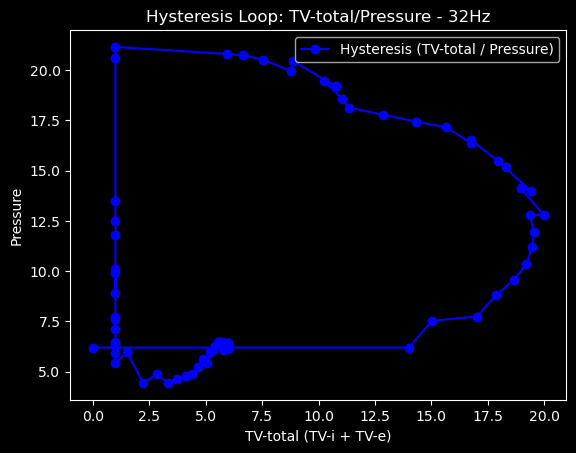

In [21]:
Random_ids = pd.DataFrame()
Random_ids = Final_ClusterSet[Final_ClusterSet['breath_id'] == 727.0 ].copy()
Random_ids = Random_ids.sort_values(by="time_step")

Hysteresis_Dynamics: dict = field(default_factory=dict)
target_columns = ["TV-i", "TV-e","pressure", "R", "C", "time_step"]

Hysteresis_Dynamics = Random_ids[target_columns].to_dict(orient ='list')
Plot_Hysteresis(Hysteresis_Dynamics)

In [82]:
Final_ClusterSet.to_csv("Final_ClusterSet.csv")